## Assignment 1 - Exploring CNNs on CIFAR-10 dataset
### Team members:
#### - Kaleb Roncatti de Souza
#### - Nelson Gomes Brasil Junior

In [14]:
!pip3 install visualkeras

In [28]:
import tensorflow as tf
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
from tensorflow.keras import layers
from sklearn.utils.class_weight import compute_class_weight
import visualkeras
import os
import random as rn
from keras import callbacks
from keras.activations import leaky_relu, relu, sigmoid


rs = 321
# Setting up random state to specific seed so we can have reproductibility
os.environ['PYTHONHASHSEED']=str(rs)
np.random.seed(rs)
tf.random.set_seed(rs)
rn.seed(rs)

In [16]:
# Loading train and test set
(x_train , y_train), (x_test , y_test) = tf.keras.datasets.cifar10.load_data()

In [17]:
# Function to shuffle
def shuffle_tensor(x: np.ndarray , y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    indices = tf.range(start=0, limit=tf.shape(x)[0], dtype=tf.int32)
    shuffled_indices = tf.random.shuffle(indices, seed=rs)
    return tf.gather(x, shuffled_indices), tf.gather(y, shuffled_indices)

# Function to split dataset
def split_dataset(x: np.ndarray, y: np.ndarray, percentage: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    if len(x) != len(y):
        raise ValueError("array x and y must have the same length")
    
    # Shuffling dataset
    x, y = shuffle_tensor(x=x, y=y)

    # Finding the splits after shuffling
    total_elements = len(y)
    data = int(percentage * total_elements)
    return x[0:data], y[0:data], x[data:], y[data:]


In [18]:
#################################################################
## Atividade 1. Splitting training and validation
x_train, y_train, x_val, y_val = split_dataset(x=x_train, y=y_train, percentage = 0.8)
print(f"We splitted the training dataset using the following percentage: {len(x_train)/(len(x_train) + len(x_val))}")
print(f"Training dataset has the following shape: x ==> {x_train.shape}, y ==> {y_train.shape}")
print(f"Validation dataset has the following shape: x ==> {x_val.shape}, y ==> {y_val.shape}")

We splitted the training dataset using the following percentage: 0.8
Training dataset has the following shape: x ==> (40000, 32, 32, 3), y ==> (40000, 1)
Validation dataset has the following shape: x ==> (10000, 32, 32, 3), y ==> (10000, 1)


In [19]:
# Normalize data between [0, 1]
x_train = tf.cast(x_train, tf.float32) / 255.0
x_val = tf.cast(x_val, tf.float32) / 255.0
x_test = tf.cast(x_test, tf.float32) / 255.0


# One hot encoding on labels
num_classes = len(np.unique(y_train))
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_oh = tf.keras.utils.to_categorical(y_val, num_classes)
y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes)
print(x_train.shape, y_train_oh.shape)

(40000, 32, 32, 3) (40000, 10)


In [20]:
# Checking if we have a balanced dataset
# Para o conjunto de treino
unique, counts = np.unique(y_train, return_counts=True)
print("Train ---> ", dict(zip(unique, counts)))
unique, counts = np.unique(y_val, return_counts=True)
print("Validation ---> ", dict(zip(unique, counts)))

Train --->  {0: 4012, 1: 3998, 2: 4034, 3: 3993, 4: 4006, 5: 4007, 6: 4035, 7: 4006, 8: 3947, 9: 3962}
Validation --->  {0: 988, 1: 1002, 2: 966, 3: 1007, 4: 994, 5: 993, 6: 965, 7: 994, 8: 1053, 9: 1038}


We can consider that the dataset is more or less balanced. We could also adjust the weights based on their proportion, but for simplicity, let's keep going considering the dataset is completely balanced.

In [21]:
print(x_train[0].shape)


(32, 32, 3)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 7200)              0         
                                                                 
 dense_4 (Dense)             (None, 10)                72010     
                                                                 
Total params: 72,906
Trainable params: 72,906
Non-trainable params: 0
_________________________________________________________________


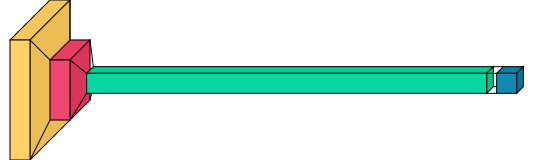

In [29]:
#################################################################
## Atividade 2. Creating a very simple convolutional neural net

def create_baseline_model(input_shape=x_train[0].shape, activation = relu) -> tf.keras.Sequential():
    model = tf.keras.Sequential()

    # Convolutional layer with 32 filters, 3x3 each
    model.add(
        layers.Conv2D(
            filters=32, 
            kernel_size=(3, 3), 
            padding='valid', 
            activation=activation, 
            input_shape=x_train[0].shape))
    #Max pooling of size 3x3
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    # Flattening
    model.add(layers.Flatten())
    # Output layer
    model.add(layers.Dense(10))

    return model

model = create_baseline_model()
model.summary()
# Taking a look at the neural net
visualkeras.layered_view(model)


In [30]:
# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [31]:
# Training the baseline model and saving it
device = '/gpu:0' # or '/cpu:0' if you don't have GPU
with tf.device(device):
    model.fit(
        x_train, y_train_oh, 
        epochs=50, 
        batch_size=64,
        validation_data=(x_val, y_val_oh),
        verbose=1,
        callbacks=[
            callbacks.TerminateOnNaN(),
            callbacks.ModelCheckpoint(
                'weights_baseline.h5',
                save_best_only=True,
                verbose=1),
        ]
        )

Epoch 1/50
624/625 [============================>.] - ETA: 0s - loss: 1.6705 - accuracy: 0.4122
Epoch 1: val_loss improved from inf to 1.54736, saving model to weights_baseline.h5
625/625 [==============================] - 14s 22ms/step - loss: 1.6699 - accuracy: 0.4123 - val_loss: 1.5474 - val_accuracy: 0.4604
Epoch 2/50
623/625 [============================>.] - ETA: 0s - loss: 1.4644 - accuracy: 0.4843
Epoch 2: val_loss improved from 1.54736 to 1.49258, saving model to weights_baseline.h5
625/625 [==============================] - 14s 23ms/step - loss: 1.4645 - accuracy: 0.4843 - val_loss: 1.4926 - val_accuracy: 0.4837
Epoch 3/50
623/625 [============================>.] - ETA: 0s - loss: 1.4232 - accuracy: 0.5028
Epoch 3: val_loss did not improve from 1.49258
625/625 [==============================] - 15s 24ms/step - loss: 1.4236 - accuracy: 0.5028 - val_loss: 1.5114 - val_accuracy: 0.4710
Epoch 4/50
624/625 [============================>.] - ETA: 0s - loss: 1.3933 - accuracy: 0.514

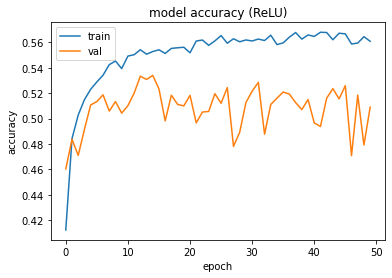

In [32]:
# Observing the model accuracy through the epochs
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy (ReLU)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [33]:
#################################################################
## Atividade 3. Exploring OTHER two activation types, since we already played with ReLU

model_sigmoid = create_baseline_model(activation=sigmoid)
model_sigmoid.summary()
# Compiling the model
model_sigmoid.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_leaky_relu = create_baseline_model(activation=leaky_relu)
model_leaky_relu.summary()
# Compiling the model
model_leaky_relu.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 7200)              0         
                                                                 
 dense_5 (Dense)             (None, 10)                72010     
                                                                 
Total params: 72,906
Trainable params: 72,906
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_10"
_________________________________________________________________
 Layer (type)              

In [34]:
# Training the baseline model and saving it with OTHER ACTIVATIONS
# Sigmoid
with tf.device(device):
    model_sigmoid.fit(
        x_train, y_train_oh, 
        epochs=50, 
        batch_size=64,
        validation_data=(x_val, y_val_oh),
        verbose=1,
        callbacks=[
            callbacks.TerminateOnNaN(),
            callbacks.ModelCheckpoint(
                'weights_baseline_sigmoid.h5',
                save_best_only=True,
                verbose=1),
        ]
        )
        
# Leaky ReLU
with tf.device(device):
    model_leaky_relu.fit(
        x_train, y_train_oh, 
        epochs=50, 
        batch_size=64,
        validation_data=(x_val, y_val_oh),
        verbose=1,
        callbacks=[
            callbacks.TerminateOnNaN(),
            callbacks.ModelCheckpoint(
                'weights_baseline_leaky_relu.h5',
                save_best_only=True,
                verbose=1),
        ]
        )

Epoch 1/50
625/625 [==============================] - ETA: 0s - loss: 2.8860 - accuracy: 0.2603
Epoch 1: val_loss improved from inf to 1.99290, saving model to weights_baseline_sigmoid.h5
625/625 [==============================] - 15s 23ms/step - loss: 2.8860 - accuracy: 0.2603 - val_loss: 1.9929 - val_accuracy: 0.2951
Epoch 2/50
623/625 [============================>.] - ETA: 0s - loss: 1.9037 - accuracy: 0.3484
Epoch 2: val_loss improved from 1.99290 to 1.83826, saving model to weights_baseline_sigmoid.h5
625/625 [==============================] - 14s 23ms/step - loss: 1.9035 - accuracy: 0.3485 - val_loss: 1.8383 - val_accuracy: 0.3601
Epoch 3/50
625/625 [==============================] - ETA: 0s - loss: 1.7240 - accuracy: 0.4042
Epoch 3: val_loss improved from 1.83826 to 1.66839, saving model to weights_baseline_sigmoid.h5
625/625 [==============================] - 14s 23ms/step - loss: 1.7240 - accuracy: 0.4042 - val_loss: 1.6684 - val_accuracy: 0.4134
Epoch 4/50
623/625 [=========

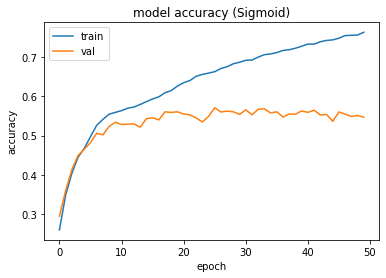

In [35]:
# Observing the model accuracy through the epochs for SIGMOID
plt.plot(model_sigmoid.history.history['accuracy'])
plt.plot(model_sigmoid.history.history['val_accuracy'])
plt.title('model accuracy (Sigmoid)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

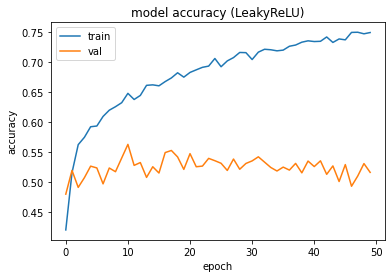

In [36]:
# Observing the model accuracy through the epochs for LeakyReLU
plt.plot(model_leaky_relu.history.history['accuracy'])
plt.plot(model_leaky_relu.history.history['val_accuracy'])
plt.title('model accuracy (LeakyReLU)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 6272)              0         
                                                                 
 dense_8 (Dense)             (None, 10)                62730     
                                                                 
Total params: 72,874
Trainable params: 72,874
Non-trainable params: 0
_________________________________________________

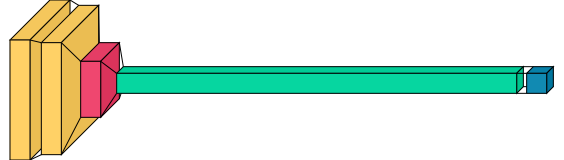

In [38]:
#################################################################
## Atividade 4. Exploring more complex CNNs to improve our model

model_complex = tf.keras.Sequential()

# Convolutional layer with 32 filters, 3x3 each
model_complex.add(
    layers.Conv2D(
        filters=32, 
        kernel_size=(3, 3), 
        padding='valid', 
        activation=leaky_relu, 
        input_shape=x_train[0].shape))
model_complex.add(
    layers.Conv2D(
        filters=32, 
        kernel_size=(3, 3), 
        padding='valid', 
        activation=leaky_relu, 
        input_shape=x_train[0].shape))
#Max pooling of size 3x3
model_complex.add(layers.MaxPooling2D(pool_size=(2, 2)))
# Flattening
model_complex.add(layers.Flatten())
# Output layer
model_complex.add(layers.Dense(10))

model_complex.summary()
# Compiling the model
model_complex.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Taking a look at the neural net
visualkeras.layered_view(model_complex)

In [39]:
with tf.device(device):
    model_complex.fit(
        x_train, y_train_oh, 
        epochs=50, 
        batch_size=64,
        validation_data=(x_val, y_val_oh),
        verbose=1,
        callbacks=[
            callbacks.TerminateOnNaN(),
            callbacks.ModelCheckpoint(
                'weights_complex.h5',
                save_best_only=True,
                verbose=1),
        ]
        )

Epoch 1/50
625/625 [==============================] - ETA: 0s - loss: 1.7488 - accuracy: 0.3993
Epoch 1: val_loss improved from inf to 1.41457, saving model to weights_complex.h5
625/625 [==============================] - 23s 35ms/step - loss: 1.7488 - accuracy: 0.3993 - val_loss: 1.4146 - val_accuracy: 0.5108
Epoch 2/50
624/625 [============================>.] - ETA: 0s - loss: 1.3930 - accuracy: 0.5289
Epoch 2: val_loss improved from 1.41457 to 1.36276, saving model to weights_complex.h5
625/625 [==============================] - 22s 35ms/step - loss: 1.3935 - accuracy: 0.5287 - val_loss: 1.3628 - val_accuracy: 0.5367
Epoch 3/50
624/625 [============================>.] - ETA: 0s - loss: 21.5194 - accuracy: 0.4353
Epoch 3: val_loss did not improve from 1.36276
625/625 [==============================] - 21s 34ms/step - loss: 21.4906 - accuracy: 0.4351 - val_loss: 4.6171 - val_accuracy: 0.2697
Epoch 4/50
625/625 [==============================] - ETA: 0s - loss: 2.1491 - accuracy: 0.416

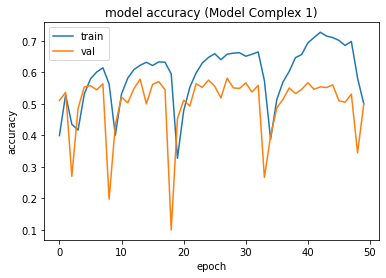

In [40]:
# Observing the model accuracy through the epochs for model complex 1
plt.plot(model_complex.history.history['accuracy'])
plt.plot(model_complex.history.history['val_accuracy'])
plt.title('model accuracy (Model Complex 1)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()